In [1]:
import numpy as np
import scipy.sparse as sp
from mpl_toolkits import mplot3d
from rom_am import ROM, DMD, KERDMDC, KERDMD, DMDc
import matplotlib.pyplot as plt
import scipy.interpolate as si
from rom_am import KERDMDC

We are learning here the system:
$$
\dot x_1 = \mu x_1\\
\dot x_2 = \lambda (x_2 - x_1^2)+ u(t)\\
$$
With $\mu = -0.01$, $\lambda = -5$ and $\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}_0 = \begin{pmatrix} .9 \\ -.7\end{pmatrix}$ and $u(t) = 0.8*cos(.11*2\pi t)$

The system can be transformed to a basis where the dynamics are linear :

$$\begin{pmatrix} y_1 \\ y_2 \\ y_3 \end{pmatrix} = \begin{pmatrix} x_1 \\ x_2 \\ x_1^2 \end{pmatrix}$$

We will show that using Kernel DMD with control gives good results, whether DMD with control (that assumes a linear system) does not.
Looking at the system equations, we use a polynomial kernel of the $2^{th}$ order.

In [2]:
## ======================= Creating the HF Data ==============================
frq = .11
ampl = .8

def create_data(init = np.array([.9, -.7]), ampl = .8, frq = .11):
    lambdd = -5.
    mu = -.01
    oper = np.array([[mu, 0., 0.], [0., lambdd, -lambdd], [0., 0, 2*mu]])
    dt = 0.14
    input_t = np.arange(0, 500, dt)
    init_data = init.copy()
    nonlinobs_init = np.array([init_data[0], init_data[1], init_data[0]**2])
    operB = np.array([[0], [1], [0]])
    
    def u(t) : return ampl * np.array([np.cos(2*np.pi*(frq)*t)])
    from scipy.integrate import solve_ivp
    def f(t, y): return oper @ y + operB @ u(t)
    sol = solve_ivp(f, [0, input_t[-1]], nonlinobs_init, t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t, dt

input_data, input_t, dt = create_data()
train_coeff = .5

In [3]:
## ======================= Taking as snaps x1 and x2 only ==============================
u_input = ampl * np.cos(2*np.pi*(frq)*input_t[:-1]).reshape((1, -1))
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

X_train = X[:, :int(train_coeff*X.shape[1])]
Y_train = Y[:, :int(train_coeff*X.shape[1])]
u_train = u_input[:, :int(train_coeff*X.shape[1])]
## ======================= DMDc Learning and predicting ==============================
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X_train,  Y = Y_train, dt = dt, Y_input=u_train, normalize=False)
predc = dromc.predict(t=0, u_input=u_input)

In [4]:
## ======================= Taking as snaps x1 and x2 only ==============================
u_input = ampl * np.cos(2*np.pi*(frq)*input_t[:-1]).reshape((1, -1))
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

X_train = X[:, :int(train_coeff*X.shape[1])]
Y_train = Y[:, :int(train_coeff*X.shape[1])]
u_train = u_input[:, :int(train_coeff*X.shape[1])]
## ======================= KerDMDc Learning and predicting ==============================
kdmdc = KERDMDC()
kromc = ROM(kdmdc)
kromc.decompose(X = X_train, Y= Y_train, dt = dt, Y_input = u_train, kernel="poly", p=2, normalize=False)
predkc = kromc.predict(t=input_t, u_input=u_input)

In [5]:
predkc = kromc.predict(t=input_t, u_input=u_input)

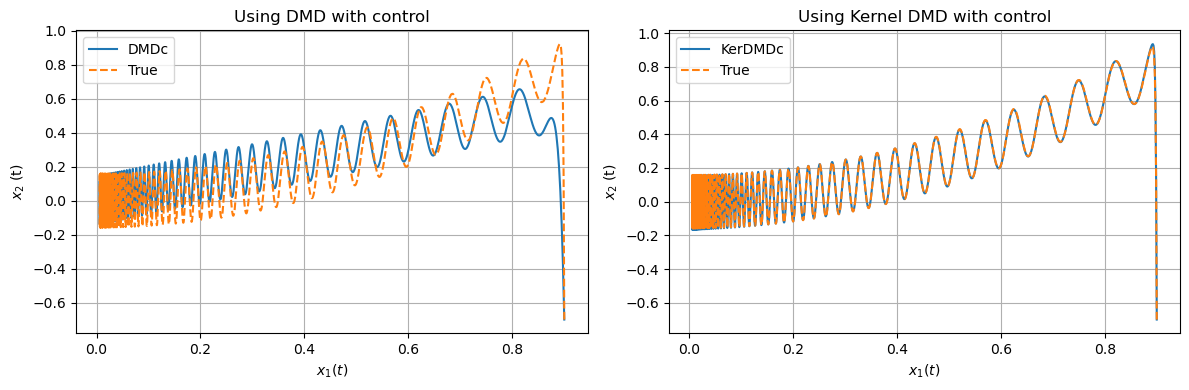

In [6]:
fig,ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(np.real(predc[0, :]), np.real(predc[1, :]), '-', label = "DMDc");
ax[0].plot(input_data[0, :], input_data[1, :], '--', label = "True");
ax[0].set_xlabel(r"$x_1 (t)$");
ax[0].set_ylabel(r"$x_2$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();
ax[0].grid();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(np.real(predkc[0, :]), np.real(predkc[1, :]), '-', label = "KerDMDc");
ax[1].plot(input_data[0, :], input_data[1, :], '--', label = "True");
ax[1].set_xlabel(r"$x_1 (t)$");
ax[1].set_ylabel(r"$x_2$ (t)");
ax[1].legend();
ax[1].grid();

plt.tight_layout();

You can change the initial conditions and/or the forcing term (moderately)

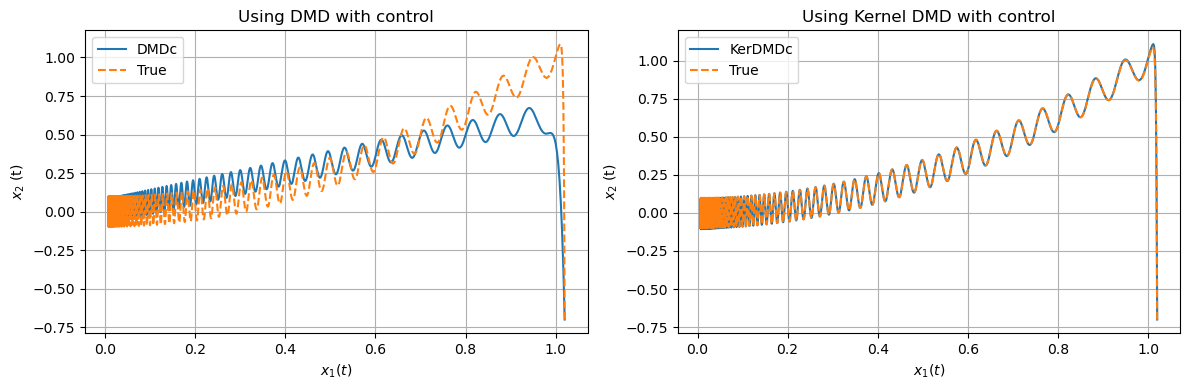

In [7]:
new_init = np.array([1.02, -0.7])
new_ampl = .5
new_frq = .14
u_input = new_ampl * np.cos(2*np.pi*(new_frq)*input_t[:-1]).reshape((1, -1))

predkc = kromc.predict(t=input_t, u_input=u_input, init = new_init)
predc = dromc.predict(t=0, u_input=u_input, init = new_init)
input_data, input_t, dt = create_data(init = new_init, ampl = new_ampl, frq = new_frq)


fig,ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(np.real(predc[0, :]), np.real(predc[1, :]), '-', label = "DMDc");
ax[0].plot(input_data[0, :], input_data[1, :], '--', label = "True");
ax[0].set_xlabel(r"$x_1 (t)$");
ax[0].set_ylabel(r"$x_2$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();
ax[0].grid();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(np.real(predkc[0, :]), np.real(predkc[1, :]), '-', label = "KerDMDc");
ax[1].plot(input_data[0, :], input_data[1, :], '--', label = "True");
ax[1].set_xlabel(r"$x_1 (t)$");
ax[1].set_ylabel(r"$x_2$ (t)");
ax[1].legend();
ax[1].grid();

plt.tight_layout();

## Non linear spring mass

We apply the same analysis on an elastic spring with a nonlinear behavior : 
$$
m_p \ddot{u}(t) = k (L(t) - L_{s0}) + \mu (L(t) - L_0)³ + A p(t)
$$

Where $L(t) = L_{se} - u(t)$
<==>
$$
\ddot{u}(t) = a u(t)^3 + b u(t)^2 + c u(t) + d_1 + d_2 p(t)
$$

we can thus write the acceleration $\ddot u = \dot v$ and the nonlinear ODE system as:
$$
(ODE1) : \pmb{\dot{y}} = 
\begin{pmatrix}
\dot{u}(t)  \\
\dot{v}(t)  \\
\end{pmatrix} = \begin{pmatrix}
{v}(t)  \\
a u(t) + b u(t)^2 + c u(t)^3 + d(t)\\
\end{pmatrix} = f(\pmb{y}, t)$$
with
$a = \frac{K}{m_p} -  \frac{3\mu u_0²}{m_p}$
$b = \frac{3\mu u_0}{m_p}$
$c = -\frac{\mu}{m_p}$


$d(t) = \frac{\mu}{m_p}u_0³ + \frac{K}{m_p}u_0 + \frac{A}{m_p}p(t) = d_1 + d_2 * p(t)$
and 
$u_0 = L_{se} - L_{0}$
The notation is matching that used in ([E.Lefrançois and J-P, Boufflet, 2010](https://doi.org/10.1137/090758313))

Experiments showed a radial kernel with `sig = .4` gives good results.

In [8]:
def create_data(pres, ntt, freq=0, init = 1.2):
    mass = 1000
    rigid = 1e7
    mu_coeff = 6
    mu = mu_coeff * rigid / 0.2
    A = 1
    pres_init0 = 1e5
    Ls0 = init
    L0 = 1
    if freq:
        p = lambda t : pres * np.sin(2 * np.pi * freq * t)
    else:
        p = lambda t : pres

    a_ = rigid;
    b_ = mu;
    c_ = A * pres_init0;
    interm = (((np.sqrt((27 * b_ * c_**2 + 4 * a_**3) / b_)) / (b_ * 2 * 3**(3. / 2.))) - c_ / (2 * b_))**(1. / 3.);
    u0 = interm - a_ / (3 * b_ * interm);

    a = -rigid/mass - 3*mu*(u0**2)/mass
    b = 3*mu*u0/mass
    c = -mu/mass
    d1 = (u0**3)*mu/mass + rigid * u0/mass 
    d2 = A/mass
    d = lambda t : d1 + d2 * p(t)
    model_param = lambda t : np.array([a, b, c, d(t), d1, d2])
    v_dot = lambda u, t : c * u**3 + b * u**2 + a * u + d(t)

    dt = 6e-4
    input_t = np.arange(ntt)*dt

    from scipy.integrate import solve_ivp
    def f(t, y): return np.array([y[1], v_dot(y[0], t)])
    sol = solve_ivp(f, [0, input_t[-1]], np.array([(Ls0 - L0), 0]), t_eval = input_t)
    input_data = sol.y.copy()
    
    return input_data, input_t,dt, v_dot, model_param

ntt_data = 500
ntt_pred = 1400
frq = 19
ampl = 4e6
input_data, input_t, dt, v_dot, model_param = create_data(ampl, ntt_data, frq)
pred_t = np.arange(ntt_pred)*dt
train_coeff = 1.

In [9]:
## ======================= Taking as snaps u(t) and v(t) only ==============================
u_input = ampl * np.sin(2 * np.pi * frq * input_t[:-1]).reshape((1, -1))
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

## ======================= DMDc Learning and predicting ==============================
u_input_pr = ampl * np.sin(2 * np.pi * frq * pred_t[:-1]).reshape((1, -1))
dmdc = DMDc()
dromc = ROM(dmdc)
dromc.decompose(X,  Y = Y, dt = dt, Y_input=u_input, normalize = True)
predc = np.real(dromc.predict(t=0, u_input=u_input_pr))

In [10]:
## ======================= Taking as snaps u(t) and v(t) only ==============================
u_input = ampl * np.sin(2 * np.pi * frq * input_t[:-1]).reshape((1, -1))
X = input_data[:2, :-1]
Y = input_data[:2, 1::]

X_train = X[:, :int(train_coeff*X.shape[1])]
Y_train = Y[:, :int(train_coeff*Y.shape[1])]
u_train = u_input[:, :int(train_coeff*u_input.shape[1])]
t_tr_f = input_t[:int(train_coeff*u_input.shape[1])]
## ======================= Kernel DMDc Learning and predicting ==============================
u_input_pr = ampl * np.sin(2 * np.pi * frq * pred_t[:-1]).reshape((1, -1))
kdmdc = KERDMDC()
kdromc = ROM(kdmdc)
kdromc.decompose(X_train,  Y = Y_train, dt = dt, Y_input = u_train, kernel = "radial", sig=.4, normalize = True)
kpredc = np.real(kdromc.predict(t=0, u_input=u_input_pr))

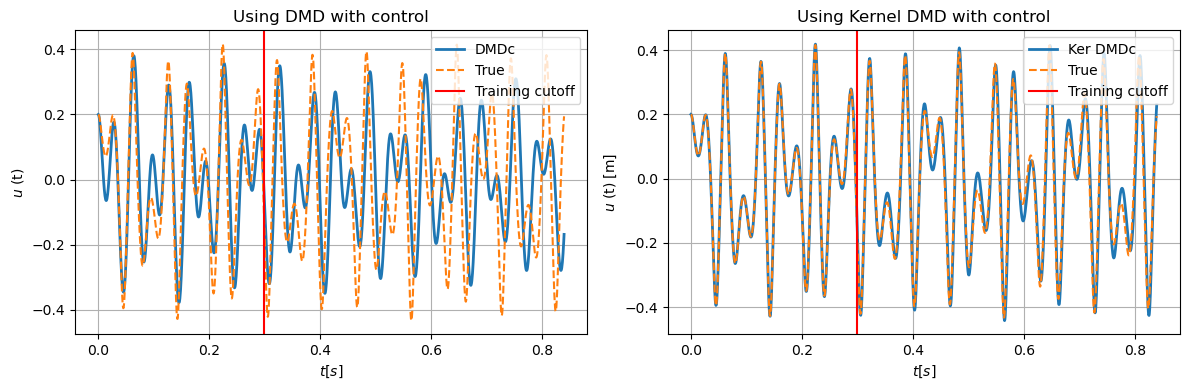

In [11]:
input_data_tst, input_t_tst, _, _, _ = create_data(ampl, ntt_pred, frq)
fig,ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(pred_t, predc[0, :], linewidth = 2., label = 'DMDc');
ax[0].plot(input_t_tst, input_data_tst[0, :], '--', label = 'True');
ax[0].axvline(t_tr_f[-1], color='r', label = 'Training cutoff');
ax[0].set_xlabel(r"$t [s]$");
ax[0].set_ylabel(r"$u$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();
ax[0].grid();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(pred_t, kpredc[0, :], linewidth = 2., label = 'Ker DMDc');
ax[1].plot(input_t_tst, input_data_tst[0, :], '--', label = 'True');
ax[1].set_xlabel(r"$t [s]$");
ax[1].set_ylabel(r"$u$ (t) [m]");
ax[1].axvline(t_tr_f[-1], color='r', label = 'Training cutoff');
ax[1].legend();
ax[1].grid();

plt.tight_layout();

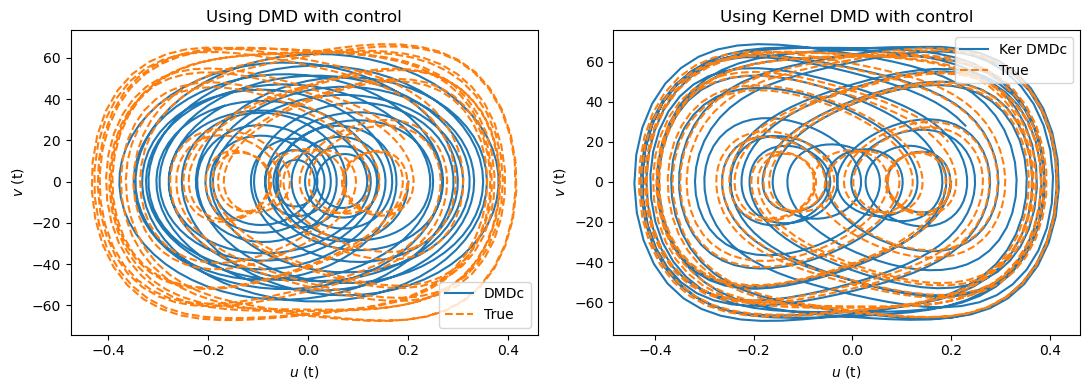

In [12]:
input_data_tst, input_t_tst, _, _, _ = create_data(ampl, ntt_pred, frq)
fig,ax = plt.subplots(1, 2, figsize = (11, 4))

ax[0].plot(predc[0, :], predc[1, :], label = 'DMDc');
ax[0].plot(input_data_tst[0, :], input_data_tst[1, :], '--', label = 'True');
ax[0].set_xlabel(r"$u$ (t)");
ax[0].set_ylabel(r"$v$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(kpredc[0, :], kpredc[1, :], label = 'Ker DMDc');
ax[1].plot(input_data_tst[0, :], input_data_tst[1, :], '--', label = 'True');
ax[1].set_xlabel(r"$u$ (t)");
ax[1].set_ylabel(r"$v$ (t)");
ax[1].legend();

plt.tight_layout();

You can change the initial conditions and/or the forcing term (moderately)

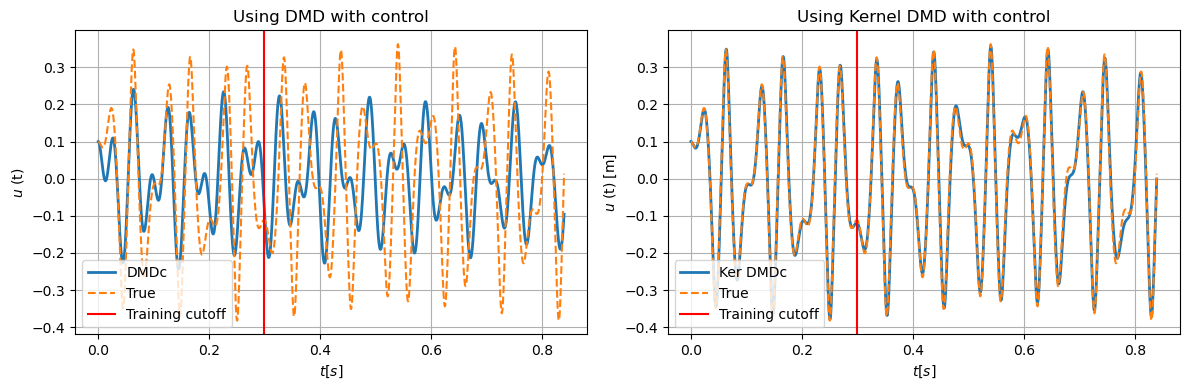

In [13]:
new_ampl = 3e6
new_init = 1.1
new_frq = 19

u_input_pr = new_ampl * np.sin(2 * np.pi * new_frq * pred_t[:-1]).reshape((1, -1))
kpredc = np.real(kdromc.predict(t=0, u_input=u_input_pr, init = np.array([(new_init-1.)/kdromc.snap_norms[0], 0])))
predc = np.real(dromc.predict(t=0, u_input=u_input_pr, init = np.array([(new_init-1.)/kdromc.snap_norms[0], 0])))

input_data_tst, input_t_tst, _, _, _ = create_data(new_ampl, ntt_pred, new_frq, init = new_init)
fig,ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(pred_t, predc[0, :], linewidth = 2., label = 'DMDc');
ax[0].plot(input_t_tst, input_data_tst[0, :], '--', label = 'True');
ax[0].axvline(t_tr_f[-1], color='r', label = 'Training cutoff');
ax[0].set_xlabel(r"$t [s]$");
ax[0].set_ylabel(r"$u$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();
ax[0].grid();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(pred_t, kpredc[0, :], linewidth = 2., label = 'Ker DMDc');
ax[1].plot(input_t_tst, input_data_tst[0, :], '--', label = 'True');
ax[1].set_xlabel(r"$t [s]$");
ax[1].set_ylabel(r"$u$ (t) [m]");
ax[1].axvline(t_tr_f[-1], color='r', label = 'Training cutoff');
ax[1].legend();
ax[1].grid();

plt.tight_layout();

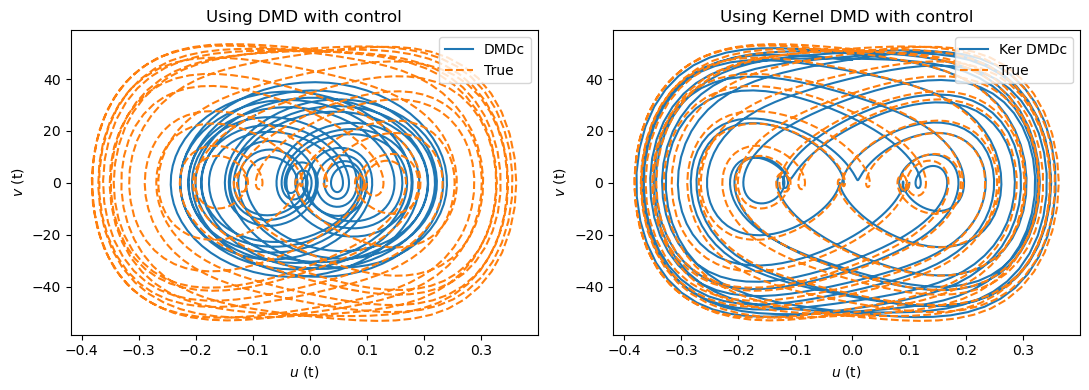

In [14]:
fig,ax = plt.subplots(1, 2, figsize = (11, 4))

ax[0].plot(predc[0, :], predc[1, :], label = 'DMDc');
ax[0].plot(input_data_tst[0, :], input_data_tst[1, :], '--', label = 'True');
ax[0].set_xlabel(r"$u$ (t)");
ax[0].set_ylabel(r"$v$ (t)");
ax[0].set_title("Using DMD with control");
ax[0].legend();

ax[1].set_title("Using Kernel DMD with control");
ax[1].plot(kpredc[0, :], kpredc[1, :], label = 'Ker DMDc');
ax[1].plot(input_data_tst[0, :], input_data_tst[1, :], '--', label = 'True');
ax[1].set_xlabel(r"$u$ (t)");
ax[1].set_ylabel(r"$v$ (t)");
ax[1].legend();

plt.tight_layout();